In [9]:
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything.build_sam import build_siamese_sam
from segment_anything.dataloader import MedicalDataset
from segment_anything.utils import ContrasiveStructureLoss
from torchvision.transforms import transforms

In [47]:
sliceimg = 15
num_classes = 3
device = 'cuda:0'

15
(256, 256)


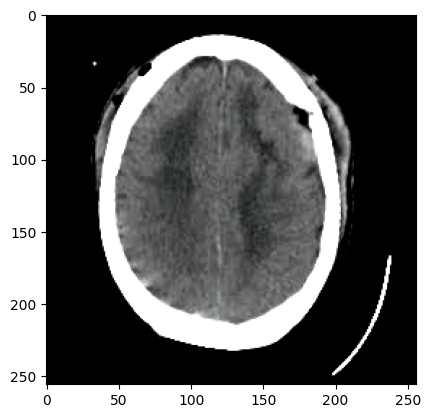

In [48]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Meningioma/CT/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
CT = cap.read()[1]
plt.imshow(CT)
CT = cv2.cvtColor(CT, cv2.COLOR_BGR2GRAY)
print(CT.shape)

15
(256, 256)


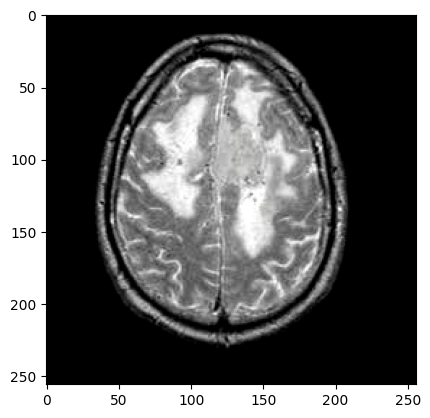

In [49]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Meningioma/MR-T2/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
MRI = cap.read()[1]
plt.imshow(MRI)
MRI = cv2.cvtColor(MRI, cv2.COLOR_BGR2GRAY)
print(MRI.shape)

(256, 256) (256, 256)


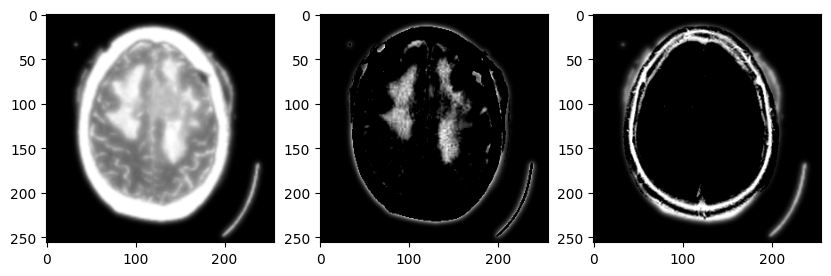

In [57]:
import cv2
import numpy as np

def build_laplacian_pyramid(image, levels):
    target_size = (256, 256)
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        laplacian_pyramid.append(laplacian)
        # print(cv2.resize(laplacian, target_size).shape)
    
    return laplacian_pyramid

def blend_images(image1, image2, levels):
    target_size = (256, 256)
    laplacian_pyramid1 = build_laplacian_pyramid(image1, levels)
    laplacian_pyramid2 = build_laplacian_pyramid(image2, levels)
    
    blended_pyramid = []
    for lap1, lap2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        blended = np.where(np.abs(lap1) > np.abs(lap2), lap1, lap2)
        blended_pyramid.append(blended)
    
    blended_image = blended_pyramid[0]
    for i in range(1, levels - 1):
        blended_image = cv2.pyrUp(blended_image)
        blended_image = cv2.add(blended_pyramid[i], blended_image) // 2

    return blended_image
# 指定金字塔的级别数量
levels = 3

# 图像融合
blended_image = blend_images(CT, MRI, levels)
blended_image = cv2.pyrUp(blended_image)
print(blended_image.shape, CT.shape)
diff_CT = cv2.subtract(blended_image, CT)
diff_MRI = cv2.subtract(blended_image, MRI)


plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(blended_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(diff_CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(diff_MRI, cmap='gray')

plt.show()
# 显示融合后的图像

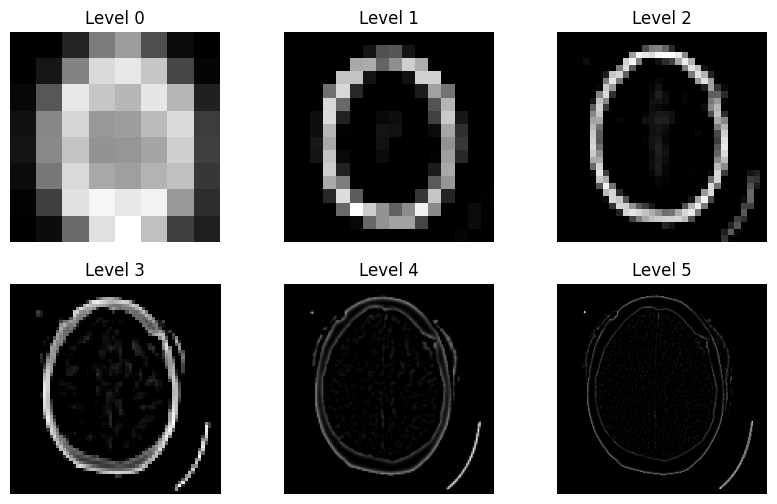

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_laplacian_pyramid(image, levels):
    # 构建高斯金字塔
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    # 构建拉普拉斯金字塔
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    
    return laplacian_pyramid

# 构建高斯-拉普拉斯金字塔
levels = 6
pyramid = gaussian_laplacian_pyramid(CT, levels)

# 创建subplot并显示金字塔中的图像
plt.figure(figsize=(10, 6))
for i in range(levels):
    plt.subplot(2, levels // 2, i + 1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

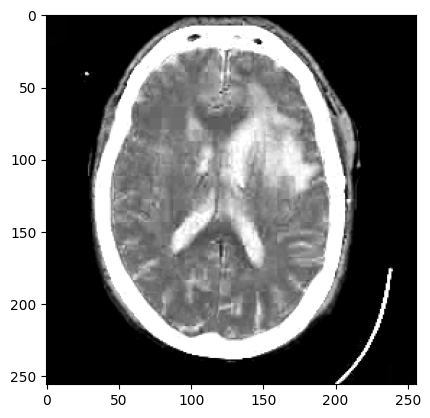

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 确保两幅图像大小相同
MRI = cv2.resize(MRI, (CT.shape[1], CT.shape[0]))

# 求两幅图像的最大值
new_img = np.maximum(CT, MRI)

# 显示融合后的图像
plt.imshow(new_img, cmap='gray')
plt.show()


In [ ]:
print(MRI.shape)

(256, 256)


In [ ]:
PATH = 'model/SiameseSAM_epoch70.pth'
SiameseSAM = build_siamese_sam(num_classes=num_classes, checkpoint=PATH).to(device)
SiameseSAM.eval()

SiameseSam(
  (image_encoder): SiameseImageEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
        ])
inputs = [transform(CT), transform(MRI)]
inputs = [i.to(device).unsqueeze(0) for i in inputs]

/home/hansenfeng/anaconda3/envs/sam/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
output = SiameseSAM(inputs)

In [ ]:
img = output[2].squeeze(0)

In [ ]:
print(img.shape)

torch.Size([1, 256, 256])


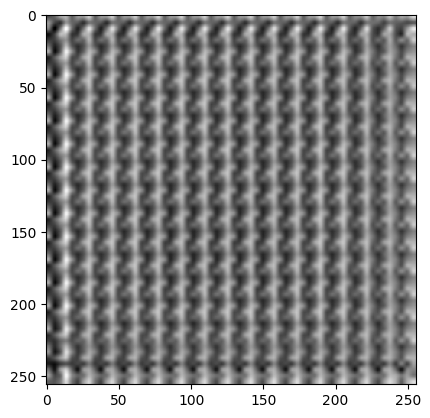

In [ ]:
plt.imshow(img.detach().cpu().permute(1,2,0).numpy(), cmap='gray')